In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [2]:
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

In [3]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(2, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u)
    z = torch.add(z1, z2)
    z = self.output(z)
    return z

# Create network
device = torch.device("cpu")
net = Net().to(device)

In [4]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_m_data, testset.x_u_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [5]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [6]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    Tz_k   = np.array(df['room_temp']).reshape(-1,1)[start: end]
    msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]

    tmp_x_u = np.concatenate((Tz_k, msa_k1), axis=1)
    tmp_y   = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

    self.x_m_data = torch.tensor(Tsa_k1, dtype=torch.float32)
    self.x_u_data = torch.tensor(tmp_x_u, dtype=torch.float32)
    self.y_data   = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.y_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp_m  = self.x_m_data[idx]
    inp_u  = self.x_u_data[idx]
    outp   = self.y_data[idx]
    sample = {'inp_m':inp_m, 'inp_u':inp_u, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 512
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [7]:
def early_stop(list, patience):
    if(len(list) > 10000):
        if(np.max(list[-patience:]) < np.max(list[0: -patience])):
            return 1
    return 0

In [8]:
# train model
max_epochs = 100000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.01)

R2_test    = np.array([])
RMSE_test  = np.array([])

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X_m = batch['inp_m']
        X_u = batch['inp_u']
        Y   = batch['outp']

        optimizer.zero_grad()
        output = net(X_m, X_u)             # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_test    = np.append(R2_test, eval(net, test_ds)[0].item())
    RMSE_test  = np.append(RMSE_test, eval(net, test_ds)[1].item())

    if(epoch%1==0):
        print(
            "epoch = %5d \t loss = %11.3f \t RMSE = %8.3f \t R2 = %8.5f \t Max_R2 = %8.5f" % 
        (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item(), np.max(R2_test))
        )
    
    if(early_stop(R2_test, 1000) == 1):
        break

epoch =     0 	 loss =  186329.578 	 RMSE =  470.800 	 R2 =  0.00191 	 Max_R2 =  0.00191
epoch =     1 	 loss =  179354.109 	 RMSE =  461.882 	 R2 =  0.00195 	 Max_R2 =  0.00195
epoch =     2 	 loss =  172524.234 	 RMSE =  452.983 	 R2 =  0.00200 	 Max_R2 =  0.00200
epoch =     3 	 loss =  165841.750 	 RMSE =  444.108 	 R2 =  0.00204 	 Max_R2 =  0.00204
epoch =     4 	 loss =  159308.359 	 RMSE =  435.258 	 R2 =  0.00209 	 Max_R2 =  0.00209
epoch =     5 	 loss =  152925.562 	 RMSE =  426.439 	 R2 =  0.00214 	 Max_R2 =  0.00214
epoch =     6 	 loss =  146694.641 	 RMSE =  417.654 	 R2 =  0.00219 	 Max_R2 =  0.00219
epoch =     7 	 loss =  140616.766 	 RMSE =  408.905 	 R2 =  0.00225 	 Max_R2 =  0.00225
epoch =     8 	 loss =  134692.812 	 RMSE =  400.197 	 R2 =  0.00230 	 Max_R2 =  0.00230
epoch =     9 	 loss =  128923.539 	 RMSE =  391.534 	 R2 =  0.00236 	 Max_R2 =  0.00236
epoch =    10 	 loss =  123309.453 	 RMSE =  382.919 	 R2 =  0.00242 	 Max_R2 =  0.00242
epoch =    11 	 loss 

KeyboardInterrupt: 

In [11]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_m_data, dataset.x_u_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 0.07343809306621552
R2:   0.997897207736969


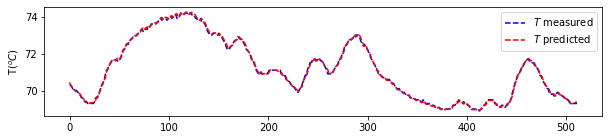

In [12]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 0.07566117495298386
R2:   0.9983908534049988


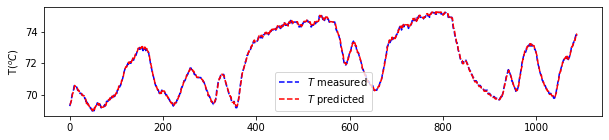

In [13]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ",   eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [9]:
print(np.argmax(R2_test))
print(np.max(R2_test))

59625
0.9984116554260254


In [14]:
PATH = 'C:/Users/tln229/Downloads/Python/1. Building/0. Saved models/Tz (1-RNN).pt'
torch.save(net, PATH)